In [72]:
import numpy as np
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import contextily as ctx
from shapely.geometry import box, LineString, MultiLineString, Point
from tqdm import tqdm
import time

# 1. Importing the data

In [2]:
zcta_path = Path.cwd().parent / 'data' / 'raw' / 'zcta5_data' / 'zcta5.shp'
zcta = gpd.read_file(zcta_path)
zcta = zcta.to_crs("EPSG:4326")
zcta = gpd.GeoDataFrame(zcta, geometry=zcta["geometry"], crs="EPSG:4326")
zcta.columns = zcta.columns.str.lower()

# importing the data for the first batch of datacenters for which the conversion address -> coordinates worked
datacenters_path = Path.cwd().parent / 'data' / 'processed' / 'successful1.csv'
datacenters = pd.read_csv(datacenters_path)
datacenters.drop('Unnamed: 0', inplace=True, axis=1)
datacenters = datacenters[(datacenters.MW_total_power >= datacenters.MW_total_power.median()) | (datacenters.sqft_total_space >= datacenters.sqft_total_space.median())]


# Convert datacenters to GeoDataFrame
gdf_datacenters = gpd.GeoDataFrame(
    datacenters, 
    geometry=gpd.points_from_xy(datacenters["longitude"], datacenters["latitude"]),
    crs="EPSG:4326"
)
gdf_datacenters.rename({'ZCTA5': 'zcta5'}, axis=1, inplace=True)


# importing the cell tower data
towers_path = Path.cwd().parent / 'data' / 'processed' / 'cell_towers_processed.csv'
towers = pd.read_csv(towers_path)
towers.drop('Unnamed: 0', inplace=True, axis=1)

# Convert cell towers to GeoDataFrame
gdf_towers = gpd.GeoDataFrame(
    towers, 
    geometry=gpd.points_from_xy(towers["lon"], towers["lat"]),
    crs="EPSG:4326"
)
gdf_towers.rename({'ZCTA5': 'zcta5'}, axis=1, inplace=True)

pop_path = Path.cwd().parent / 'data' / 'raw' / 'Population-Density-Final.xlsx'
pop = pd.read_excel(pop_path, sheet_name='DATA')
pop.rename({'Zip': 'zcta5'}, axis=1, inplace=True)
pop["zcta5"] = pop["zcta5"].astype(str)


energy_path = Path.cwd().parent / 'data' / 'raw' / 'transmission_line_data' / 'Electric_Power_Transmission_Lines_B.shp'
energy =  gpd.read_file(energy_path)
energy.rename({'ZCTA5': 'zcta5'}, axis=1, inplace=True)
energy = energy.to_crs('EPSG:4326')

substations_path = Path.cwd().parent / 'data' / 'raw' / 'Substations.csv'
substations = gpd.read_file(substations_path)
substations.columns = substations.columns.str.lower()
substations[['max_volt', 'min_volt']] = substations[['max_volt', 'min_volt']].astype(float)
substations = substations[
    (substations.type == 'SUBSTATION') & 
    (substations.status == 'IN SERVICE') & 
    (substations.zip != 'NOT AVAILABLE') &
    (substations.max_volt > 0) &
    (substations.min_volt > 0)
                          ]
substations = substations[['zip']].value_counts().to_frame().reset_index().rename({'count': 'substation_count'}, axis=1)

In [3]:
# ✅ Define the voltage classification function
def classify_voltage(voltage):
    if voltage < 1:
        return "Low Voltage (<1kV)"
    elif 1 <= voltage < 69:
        return "Medium Voltage (1-69kV)"
    elif 69 <= voltage < 230:
        return "High Voltage (69-230kV)"
    elif 230 <= voltage < 765:
        return "Extra-High Voltage (230-765kV)"
    else:
        return "Ultra-High Voltage (>765kV)"

# ✅ Apply classification
energy["Voltage_Class"] = energy["VOLTAGE"].apply(classify_voltage)

In [4]:
# ✅ Define Dallas bounding box (approximate lat/lon range)
dallas_bbox = {
    "minx": -97.5, "maxx": -96.5,
    "miny": 32.5, "maxy": 33.3
}
dallas_geom = box(dallas_bbox["minx"], dallas_bbox["miny"], dallas_bbox["maxx"], dallas_bbox["maxy"])

energy_dallas = energy[energy.geometry.intersects(dallas_geom)].copy()
gdf_datacenters_dallas = gdf_datacenters[gdf_datacenters.geometry.intersects(dallas_geom)].copy()
gdf_towers_dallas = gdf_towers[gdf_towers.geometry.intersects(dallas_geom)].copy()

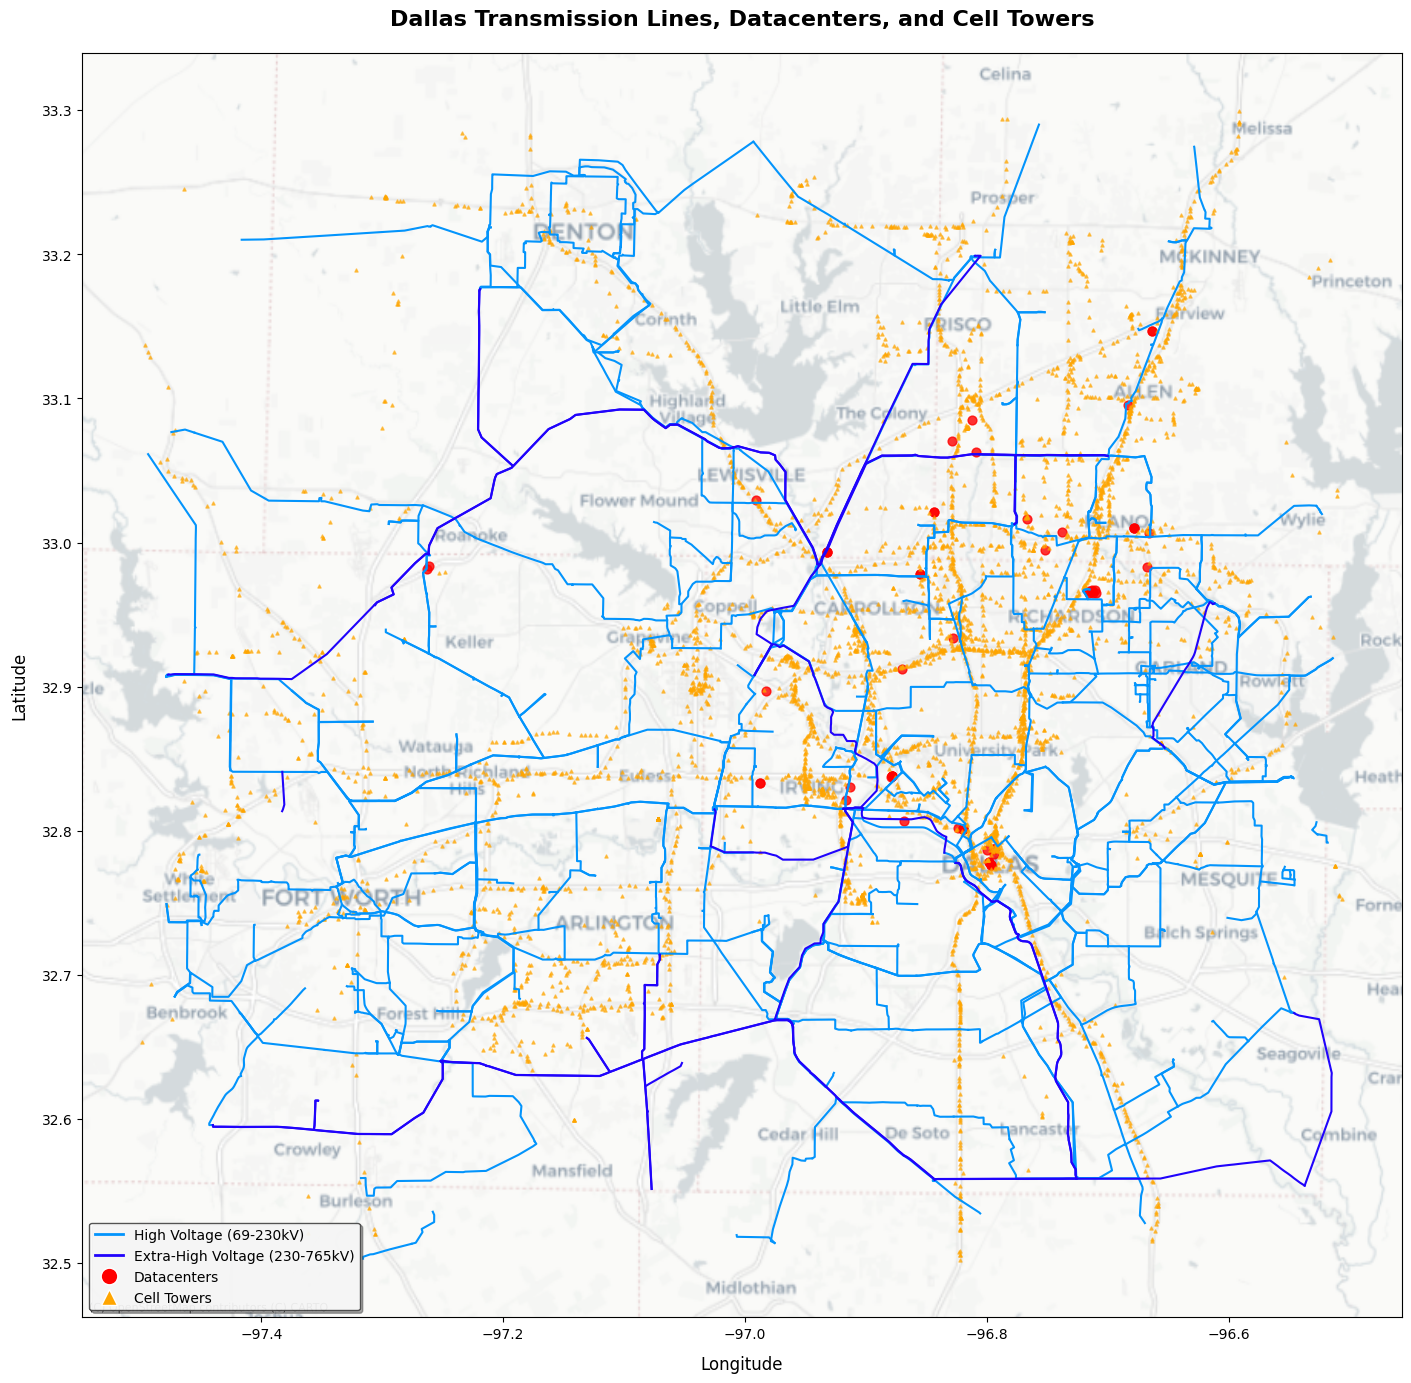

In [5]:
# ✅ Filter transmission lines within Dallas
energy_dallas_filtered = energy_dallas[
    (energy_dallas.geometry.bounds.minx >= dallas_bbox["minx"]) & 
    (energy_dallas.geometry.bounds.maxx <= dallas_bbox["maxx"]) & 
    (energy_dallas.geometry.bounds.miny >= dallas_bbox["miny"]) & 
    (energy_dallas.geometry.bounds.maxy <= dallas_bbox["maxy"])
]

# ✅ Filter only High Voltage and Extra-High Voltage lines
energy_dallas_filtered = energy_dallas_filtered[
    energy_dallas_filtered["Voltage_Class"].isin(["High Voltage (69-230kV)", "Extra-High Voltage (230-765kV)"])
]

# ✅ Filter datacenters within Dallas
gdf_datacenters_dallas = gdf_datacenters[
    (gdf_datacenters.geometry.x >= dallas_bbox["minx"]) & 
    (gdf_datacenters.geometry.x <= dallas_bbox["maxx"]) & 
    (gdf_datacenters.geometry.y >= dallas_bbox["miny"]) & 
    (gdf_datacenters.geometry.y <= dallas_bbox["maxy"])
]

# ✅ Filter cell towers within Dallas
gdf_towers_dallas = gdf_towers[
    (gdf_towers.geometry.x >= dallas_bbox["minx"]) & 
    (gdf_towers.geometry.x <= dallas_bbox["maxx"]) & 
    (gdf_towers.geometry.y >= dallas_bbox["miny"]) & 
    (gdf_towers.geometry.y <= dallas_bbox["maxy"])
]

# ✅ Define voltage classification colors (Only High & Extra-High)
voltage_colors = {
    "High Voltage (69-230kV)": "#0394fc",
    "Extra-High Voltage (230-765kV)": "#2003fc",
}

# ✅ Plot Everything Together
fig, ax = plt.subplots(figsize=(14, 14), constrained_layout=True)

# ✅ Plot Transmission Lines (Only High & Extra-High Voltage)
for category, color in voltage_colors.items():
    subset = energy_dallas_filtered[energy_dallas_filtered["Voltage_Class"] == category]
    for line in subset.geometry:
        if isinstance(line, LineString):
            x, y = line.xy
            ax.plot(x, y, color=color, linewidth=1.5, label=category)
        elif isinstance(line, MultiLineString):
            for segment in line.geoms:
                x, y = segment.xy
                ax.plot(x, y, color=color, linewidth=1.5, label=category)

# ✅ Plot Datacenters (Red Circles)
gdf_datacenters_dallas.plot(ax=ax, color="red", markersize=40, label="Datacenters", alpha=0.8)

# ✅ Plot Cell Towers (Orange Triangles)
gdf_towers_dallas.plot(ax=ax, color="orange", markersize=5, marker="^", label="Cell Towers", alpha=0.6)

# ✅ Add a basemap
ctx.add_basemap(ax, crs=gdf_datacenters_dallas.crs, source=ctx.providers.CartoDB.Positron)

# ✅ Formatting
ax.set_title("Dallas Transmission Lines, Datacenters, and Cell Towers", fontsize=16, pad=20, weight="bold")
ax.set_xlabel("Longitude", fontsize=12, labelpad=10)
ax.set_ylabel("Latitude", fontsize=12, labelpad=10)

# ✅ Create a Custom Legend with Correct Icons
legend_elements = [
    # Transmission Lines (lines in legend)
    mlines.Line2D([], [], color="#0394fc", linewidth=2, label="High Voltage (69-230kV)"),
    mlines.Line2D([], [], color="#2003fc", linewidth=2, label="Extra-High Voltage (230-765kV)"),
    
    # Datacenters (circle markers with white edge)
    mlines.Line2D([], [], 
                 marker='o', 
                 color='red',            # Inner color
                 markeredgecolor='white', # Edge color
                 markersize=12,          # Size relative to legend
                 linestyle='None',
                 label="Datacenters"),
    
    # Cell Towers (triangle markers with white edge)
    mlines.Line2D([], [], 
                 marker='^', 
                 color='orange',         # Inner color
                 markeredgecolor='white', # Edge color
                 markersize=12,          # Size relative to legend
                 linestyle='None',
                 label="Cell Towers")
]

# ✅ Add legend with proper styling
ax.legend(handles=legend_elements, 
          loc="lower left", 
          fontsize=10, 
          title_fontsize=12,
          frameon=True, 
          shadow=True, 
          facecolor='white',
          edgecolor='#404040',
          framealpha=0.9)

# ✅ Show the map
plt.show()

In [6]:
# ✅ Assign ZIP codes to datacenters
gdf_datacenters = gdf_datacenters.sjoin(zcta, predicate="within")

# ✅ Assign ZIP codes to cell towers
gdf_towers = gdf_towers.sjoin(zcta, predicate="within")

# Perform spatial join: Assign ZIP codes to transmission lines
energy = gpd.sjoin(energy, zcta, predicate="intersects")

# ✅ Keep only relevant columns
gdf_datacenters = gdf_datacenters[["zcta5", "geometry"]]
gdf_towers = gdf_towers[["zcta5", "geometry"]]

# Count datacenters per ZIP code
datacenter_counts = gdf_datacenters.groupby("zcta5").size().reset_index(name="datacenter_count")

# Count cell towers per ZIP code
tower_counts = gdf_towers.groupby("zcta5").size().reset_index(name="tower_count")

In [7]:
# ✅ Convert energy dataset to a projected CRS (e.g., EPSG:3857 or EPSG:5070 for the US)
if energy.crs != "EPSG:3857":  # EPSG:3857 is Web Mercator (meters)
    energy = energy.to_crs("EPSG:3857")

# ✅ Compute line length in kilometers
energy["line_length_km"] = energy.geometry.length / 1000  # Convert meters to km
line_density = energy.groupby("zcta5")["line_length_km"].sum().reset_index()

# Merge population density with infrastructure data
merged_df = pop.merge(datacenter_counts, on="zcta5", how="left")
merged_df = merged_df.merge(tower_counts, on="zcta5", how="left")
merged_df = merged_df.merge(line_density, on="zcta5", how="left")

# Fill NaN values (since some ZIPs may have no datacenters or towers)
merged_df.fillna(0, inplace=True)

# ✅ Ensure the CRS is in a projected coordinate system for accurate area calculation
if zcta.crs != "EPSG:3857":  
    zcta = zcta.to_crs("EPSG:3857")  # Convert to a metric-based CRS (meters)

# ✅ Compute area in square kilometers
zcta["area_km2"] = zcta.geometry.area / 1e6  # Convert from square meters to square kilometers

# ✅ Keep only necessary columns
zcta_area = zcta[["zcta5", "area_km2"]]

# ✅ Merge the area data with the existing dataset
merged_df = merged_df.merge(zcta_area, left_on="zcta5", right_on="zcta5", how="left")

In [8]:
# ✅ Compute density of cell towers
merged_df["tower_density_km2"] = merged_df["tower_count"] / merged_df["area_km2"]


In [9]:
# ✅ Convert to a binary target variable
merged_df["datacenter_built"] = (merged_df["datacenter_count"] > 0).astype(int)

# ✅ Drop the original `datacenter_count` column
merged_df.drop(columns=["datacenter_count"], inplace=True)


In [10]:
merged_df.drop(columns=["City", "St", "CitySt", "County", "Country", "Coordinates"], inplace=True)
merged_df.dropna(inplace=True)

In [11]:
# ✅ Ensure that 'pop' has a geometry column before converting
if not isinstance(pop, gpd.GeoDataFrame):
    if "long" in pop.columns and "lat" in pop.columns:
        pop = gpd.GeoDataFrame(pop, 
                               geometry=gpd.points_from_xy(pop["long"], pop["lat"]), 
                               crs="EPSG:4326")
    else:
        raise ValueError("The 'pop' dataset does not have latitude/longitude columns!")

# ✅ Ensure that 'gdf_towers' is a GeoDataFrame
if not isinstance(gdf_towers, gpd.GeoDataFrame):
    gdf_towers = gpd.GeoDataFrame(gdf_towers, geometry=gdf_towers["geometry"], crs="EPSG:4326")

# ✅ Ensure that 'energy' is a GeoDataFrame
if not isinstance(energy, gpd.GeoDataFrame):
    energy = gpd.GeoDataFrame(energy, geometry=energy["geometry"], crs="EPSG:4326")

# ✅ Ensure that 'zcta' is a GeoDataFrame
if not isinstance(zcta, gpd.GeoDataFrame):
    zcta = gpd.GeoDataFrame(zcta, geometry=zcta["geometry"], crs="EPSG:4326")

# ✅ Convert all data to EPSG:5070 for accurate distance calculations
for gdf in [gdf_towers, pop, energy, zcta]:
    if gdf.crs != "EPSG:5070":
        gdf.to_crs("EPSG:5070", inplace=True)

In [52]:
# ✅ Define radius distances in meters
radius_distances = [1000, 5000, 10000, 25000, 50000]  # 1km, 5km, 10km, 25km, 50km

# ✅ Precompute buffers (store only relevant columns)
zip_buffers = {}

# ✅ Initialize Timer
start_time = time.perf_counter()

# ✅ Compute buffers with real-time ZIP-level progress tracking
total_zips = len(zcta)

for radius in radius_distances:
    print(f"🔹 Computing buffers for {radius//1000}km radius...")

    # ✅ Create a new GeoDataFrame with only 'zcta5' and buffered geometry
    buffer_gdf = gpd.GeoDataFrame(
        {
            "zcta5": zcta["zcta5"],
            "geometry": [geom.buffer(radius) for geom in tqdm(zcta.geometry, total=total_zips, desc=f"Buffering {radius//1000}km")]
        },
        crs=zcta.crs
    )

    # ✅ Store in the dictionary
    zip_buffers[radius] = buffer_gdf

# ✅ End Timer & Print Execution Time
end_time = time.perf_counter()
print(f"✅ Buffer computation completed in {end_time - start_time:.2f} seconds.")

# ✅ Initialize result DataFrame
results = pd.DataFrame({"zcta5": zcta["zcta5"]})


🔹 Computing buffers for 1km radius...


Buffering 1km: 100%|██████████| 33791/33791 [07:56<00:00, 70.97it/s] 


🔹 Computing buffers for 5km radius...


Buffering 5km: 100%|██████████| 33791/33791 [07:59<00:00, 70.49it/s] 


🔹 Computing buffers for 10km radius...


Buffering 10km: 100%|██████████| 33791/33791 [06:35<00:00, 85.54it/s] 


🔹 Computing buffers for 25km radius...


Buffering 25km: 100%|██████████| 33791/33791 [03:16<00:00, 171.75it/s]


🔹 Computing buffers for 50km radius...


Buffering 50km: 100%|██████████| 33791/33791 [01:48<00:00, 312.11it/s]

✅ Buffer computation completed in 1655.75 seconds.


In [12]:
# Define the list of radii you saved
radius_distances = [1000, 5000, 10000, 25000, 50000]

# Initialize an empty dictionary
zip_buffers = {}

# Loop through each radius and load the corresponding GeoJSON
for radius in radius_distances:
    filename = f"{radius}.geojson"  # Adjust if your files have a different naming convention
    zip_buffers[radius] = gpd.read_file(filename)

# zip_buffers now matches the structure you originally had, 
# with each key (radius) mapping to its corresponding GeoDataFrame.


In [13]:
# ✅ Convert all zcta5 columns to string format (for safe joins)
gdf_towers["zcta5"] = gdf_towers["zcta5"].astype(str)
pop["zcta5"] = pop["zcta5"].astype(str)
energy["zcta5"] = energy["zcta5"].astype(str)
substations.rename({'zip': 'zcta5'}, inplace=True, axis=1)

# ✅ Initialize dictionary to store computed features
radius_features = {radius: pd.DataFrame({"zcta5": zip_buffers[radius]["zcta5"].astype(str)}) for radius in radius_distances}


## Calculating within-radius measures

In [15]:
energy = energy.drop(columns=["index_right"], errors="ignore")

# ✅ Compute spatial statistics for each radius
for radius in radius_distances:
    print(f"🔹 Processing spatial statistics for {radius // 1000} km radius...")

    # ✅ Get the buffer for this radius
    buffer_gdf = zip_buffers[radius]
    buffer_gdf["zcta5"] = buffer_gdf["zcta5"].astype(str)  # Ensure consistency

    # ✅ Count towers within each buffer
    tower_counts = gpd.sjoin(gdf_towers, buffer_gdf, predicate="within")
    tower_counts = tower_counts.groupby("zcta5_right").size().reset_index(name=f"tower_count_{radius//1000}km")
    tower_counts.rename(columns={"zcta5_right": "zcta5"}, inplace=True)

    # ✅ Sum population within each buffer
    pop_counts = gpd.sjoin(pop, buffer_gdf, predicate="within")
    pop_counts = pop_counts.groupby("zcta5_right")["population"].sum().reset_index(name=f"population_{radius//1000}km")
    pop_counts.rename(columns={"zcta5_right": "zcta5"}, inplace=True)

    # ✅ Sum transmission line length within each buffer
    line_lengths = gpd.sjoin(energy, buffer_gdf, predicate="intersects")
    line_lengths = line_lengths.groupby("zcta5_right")["line_length_km"].sum().reset_index(name=f"line_length_{radius//1000}km")
    line_lengths.rename(columns={"zcta5_right": "zcta5"}, inplace=True)

    # ✅ Merge these statistics into the results dictionary
    radius_features[radius] = radius_features[radius].merge(tower_counts, on="zcta5", how="left")
    radius_features[radius] = radius_features[radius].merge(pop_counts, on="zcta5", how="left")
    radius_features[radius] = radius_features[radius].merge(line_lengths, on="zcta5", how="left")

    # ✅ Fill NaN values with 0 (some ZIPs may have no towers, population, or transmission lines)
    radius_features[radius].fillna(0, inplace=True)

# ✅ Merge all radius-based features into `merged_df`
for radius in radius_distances:
    merged_df = merged_df.merge(radius_features[radius], on="zcta5", how="left")

merged_df = merged_df.merge(substations, on="zcta5", how="left").fillna(0)


🔹 Processing spatial statistics for 1 km radius...
🔹 Processing spatial statistics for 5 km radius...
🔹 Processing spatial statistics for 10 km radius...
🔹 Processing spatial statistics for 25 km radius...
🔹 Processing spatial statistics for 50 km radius...


# Machile Learning Modelling

In [46]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier

# Logit Cross Validation

In [108]:
# -----------------------------
# Step 3. Prepare Feature Matrix and Target
# -----------------------------
# List of all features: original + transformed.
all_features = level_features + list(log_cols.keys()) + list(square_cols.keys())
X = merged_df[all_features].copy()
y = merged_df["datacenter_built"]

# -----------------------------
# Step 4. Impute Missing Values (Median Imputation)
# -----------------------------
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=all_features)

# -----------------------------
# Step 5. Scale the Features
# -----------------------------
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=all_features)

# -----------------------------
# Step 6. Train-Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# -----------------------------
# Step 7. Evaluate Feature Transformations with Cross-Validation
# -----------------------------
def evaluate_feature_transformations(X, y):
    """
    For each base feature, evaluate these transformations:
      - level (original feature)
      - log (if available)
      - square (if available)
      - level+log (if available)
      - level+square (if available)
      
    The transformation yielding the highest 5-fold cross-validated ROC-AUC is selected.
    """
    feature_performance = {}
    
    for col in level_features:
        transformations = {
            "level": X[[col]],
            "log": X[[f"log_{col}"]] if f"log_{col}" in X.columns else None,
            "square": X[[f"square_{col}"]] if f"square_{col}" in X.columns else None,
            "level+log": X[[col, f"log_{col}"]] if f"log_{col}" in X.columns else None,
            "level+square": X[[col, f"square_{col}"]] if f"square_{col}" in X.columns else None
        }
        
        best_auc = 0
        best_transform = "level"
        for transform_name, X_sub in transformations.items():
            if X_sub is not None:
                model = LogisticRegression(max_iter=1000)
                auc = np.mean(cross_val_score(model, X_sub, y, cv=5, scoring="roc_auc"))
                if auc > best_auc:
                    best_auc = auc
                    best_transform = transform_name
                    
        feature_performance[col] = (best_transform, best_auc)
    return feature_performance

# Evaluate transformations using the training data.
feature_scores = evaluate_feature_transformations(X_train, y_train)

# -----------------------------
# Step 8. Select the Best Transformation for Each Variable
# -----------------------------
selected_features = []
explanation = []  # To store rationale for selected features.
for feature, (best_transform, auc) in feature_scores.items():
    if best_transform == "level":
        selected_features.append(feature)
        explanation.append(f"For '{feature}', the original value was best (ROC-AUC: {auc:.4f}).")
    elif best_transform == "log":
        selected_features.append(f"log_{feature}")
        explanation.append(f"For '{feature}', the log transformation ('log_{feature}') was best (ROC-AUC: {auc:.4f}).")
    elif best_transform == "square":
        selected_features.append(f"square_{feature}")
        explanation.append(f"For '{feature}', the square transformation ('square_{feature}') was best (ROC-AUC: {auc:.4f}).")
    elif best_transform == "level+log":
        selected_features.extend([feature, f"log_{feature}"])
        explanation.append(f"For '{feature}', combining original and log ('{feature}' & 'log_{feature}') was best (ROC-AUC: {auc:.4f}).")
    elif best_transform == "level+square":
        selected_features.extend([feature, f"square_{feature}"])
        explanation.append(f"For '{feature}', combining original and square ('{feature}' & 'square_{feature}') was best (ROC-AUC: {auc:.4f}).")

# Display the selected features and rationale.
print("Selected Features and Their Transformations:")
for exp in explanation:
    print(exp)

# -----------------------------
# Step 9. Retrain Final Model Using Selected Features
# -----------------------------
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_train_selected, y_train)

# -----------------------------
# Step 10. Evaluate Final Model Performance
# -----------------------------
y_pred_prob = final_model.predict_proba(X_test_selected)[:, 1]
final_roc_auc = roc_auc_score(y_test, y_pred_prob)
print("\nFinal Model Performance on Test Set:")
print(f"ROC-AUC Score: {final_roc_auc:.4f}")

# -----------------------------
# Step 11. Predict Probabilities for All ZIP Codes
# -----------------------------
# Use the same preprocessed (imputed & scaled) full dataset.
X_final_selected = X_scaled[selected_features]
merged_df["predicted_prob"] = final_model.predict_proba(X_final_selected)[:, 1]

# -----------------------------
# Step 12. Merge Predictions with Spatial Data
# -----------------------------
# Ensure that the join key is of the same type in both DataFrames.
merged_df["zcta5"] = merged_df["zcta5"].astype(str)
zcta["zcta5"] = zcta["zcta5"].astype(str)
zcta_map = zcta.merge(merged_df, on="zcta5", how="left")

# -----------------------------
# Final Summary: Output Variables Included and the Rationale
# -----------------------------
print("\nFinal Selected Variables for the Model:")
for feature, (transformation, auc) in feature_scores.items():
    if transformation == "level":
        print(f" - {feature}: original value chosen (ROC-AUC: {auc:.4f})")
    elif transformation == "log":
        print(f" - log_{feature}: log transformation chosen (ROC-AUC: {auc:.4f})")
    elif transformation == "square":
        print(f" - square_{feature}: square transformation chosen (ROC-AUC: {auc:.4f})")
    elif transformation == "level+log":
        print(f" - {feature} and log_{feature}: combined transformation chosen (ROC-AUC: {auc:.4f})")
    elif transformation == "level+square":
        print(f" - {feature} and square_{feature}: combined transformation chosen (ROC-AUC: {auc:.4f})")

print("\nReasoning:")
print("Each variable's transformation was selected based on cross-validated ROC-AUC performance. "
      "The chosen transformation (or combination) that achieved the highest ROC-AUC on training folds "
      "was retained to maximize predictive performance. Consistent preprocessing (imputation and scaling) "
      "and ensuring join keys are of the same type during the merge guarantee a robust end-to-end pipeline.")


Selected Features and Their Transformations:
For 'population', the original value was best (ROC-AUC: 0.8355).
For 'density', the original value was best (ROC-AUC: 0.8618).
For 'tower_count', the original value was best (ROC-AUC: 0.8251).
For 'line_length_km', the original value was best (ROC-AUC: 0.5122).
For 'area_km2', the original value was best (ROC-AUC: 0.7026).
For 'tower_density_km2', the original value was best (ROC-AUC: 0.8490).
For 'tower_count_1km', the original value was best (ROC-AUC: 0.8488).
For 'population_1km', the original value was best (ROC-AUC: 0.8750).
For 'line_length_1km', the log transformation ('log_line_length_1km') was best (ROC-AUC: 0.5032).
For 'tower_count_5km', the original value was best (ROC-AUC: 0.8572).
For 'population_5km', the original value was best (ROC-AUC: 0.9011).
For 'line_length_5km', combining original and log ('line_length_5km' & 'log_line_length_5km') was best (ROC-AUC: 0.5596).
For 'tower_count_10km', combining original and square ('towe

# Cross-Validated Logit Estimation

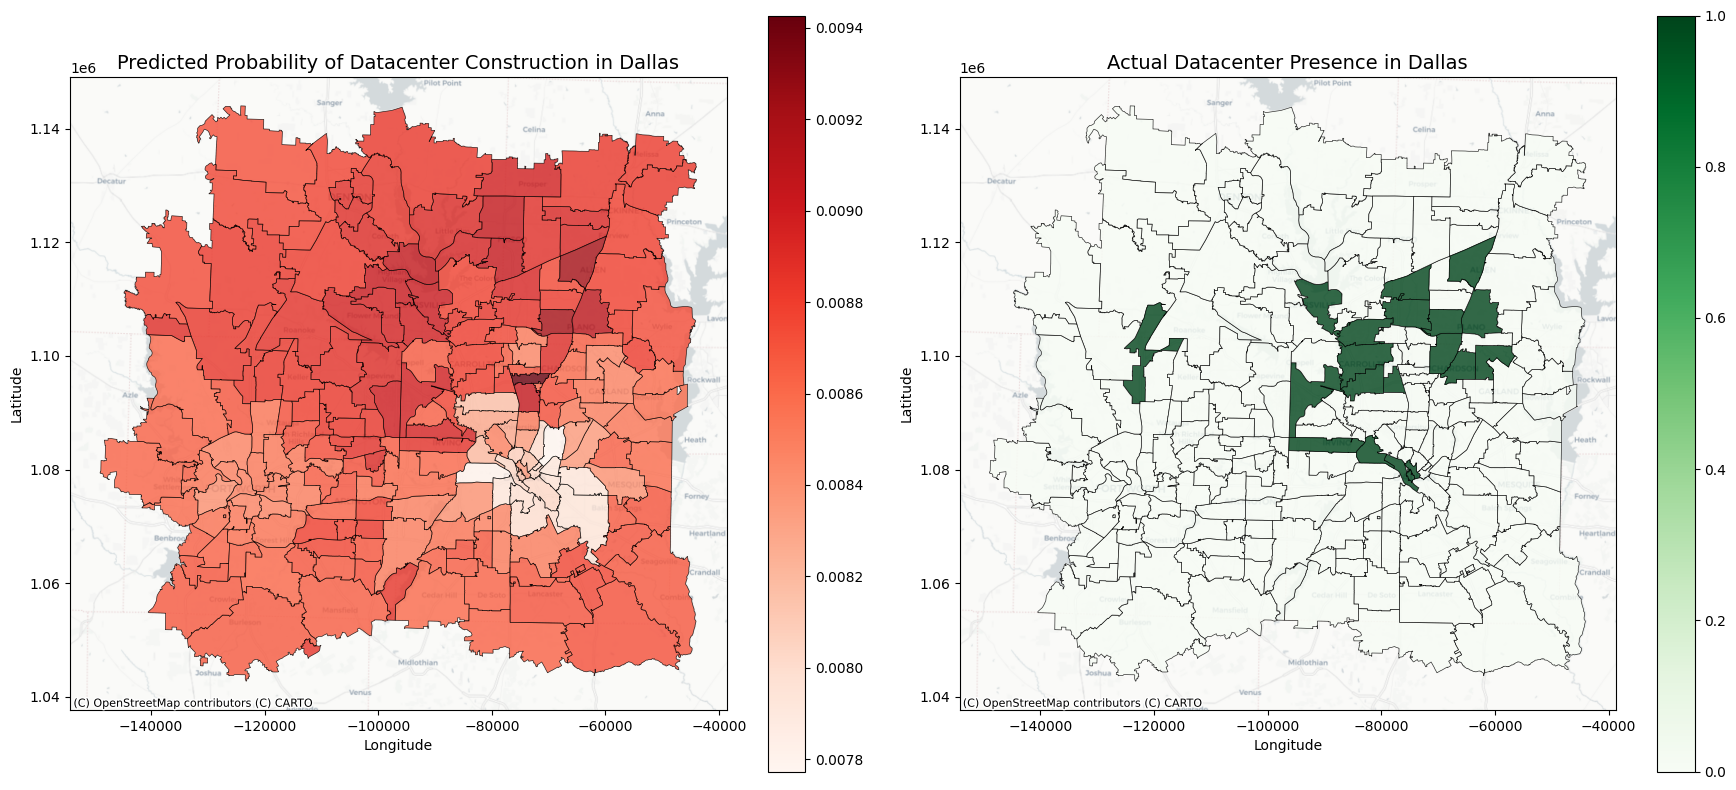

In [208]:
# =============================================================================
# ASSUMPTIONS:
# - merged_df is a DataFrame containing at least these columns:
#       "population_25km", "line_length_25km", "population_10km",
#       "square_tower_count_1km", "population_5km", "line_length_10km",
#       "square_tower_count_50km", "square_tower_count_5km",
#   plus the target "datacenter_built", ZIP code "zcta5", "lat", and "long".
# - zcta is a GeoDataFrame containing ZIP code geometries with a "zcta5" field.
# =============================================================================

# -----------------------------
# 1. Define the Final Feature List
# -----------------------------
final_features = [
    "population_25km", "line_length_25km", "population_10km",
    "square_tower_count_1km", "population_5km", "line_length_10km",
    "square_tower_count_50km", "square_tower_count_5km"
]

# -----------------------------
# 2. Preprocess the Data
# -----------------------------
# Optionally scale selected variables.
cols_to_scale = ["population_25km", "line_length_25km", "population_10km",
                 "population_5km", "line_length_10km"]
scaler = MinMaxScaler()
merged_df[cols_to_scale] = scaler.fit_transform(merged_df[cols_to_scale])

# Drop extraneous columns (if any) and fill missing values.
if "State" in merged_df.columns:
    merged_df.drop("State", axis=1, inplace=True)
merged_df.fillna(0, inplace=True)

# -----------------------------
# 3. Define Features (X) and Target (y)
# -----------------------------
X = merged_df[final_features].copy()
y = merged_df["datacenter_built"]

# -----------------------------
# 4. Split Data into Training (US ex-Dallas) and Test (Dallas) using lat/long boundaries
# -----------------------------
# Approximate bounding box for Dallas:
dallas_bbox = {
    "minx": -97.5, "maxx": -96.5,
    "miny": 32.5, "maxy": 33.3
}

# Subset Dallas using the lat/long boundaries.
dallas_df = merged_df[
    (merged_df["long"] >= dallas_bbox["minx"]) & (merged_df["long"] <= dallas_bbox["maxx"]) &
    (merged_df["lat"] >= dallas_bbox["miny"]) & (merged_df["lat"] <= dallas_bbox["maxy"])
].copy()

# All other observations become the training set.
train_df = merged_df.drop(dallas_df.index)

X_train = train_df[final_features].copy()
y_train = train_df["datacenter_built"]
X_test_dallas = dallas_df[final_features].copy()
y_test_dallas = dallas_df["datacenter_built"]

# -----------------------------
# 5. Train Logistic Regression Model on US ex-Dallas
# -----------------------------
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# -----------------------------
# 6. Predict Probabilities for Dallas Test Set
# -----------------------------
dallas_df["predicted_prob"] = model.predict_proba(X_test_dallas)[:, 1]

# -----------------------------
# 7. Merge Predictions with Spatial Data for Plotting
# -----------------------------
# Ensure that the join key "zcta5" is of the same type.
merged_df["zcta5"] = merged_df["zcta5"].astype(str)
dallas_df["zcta5"] = dallas_df["zcta5"].astype(str)
zcta["zcta5"] = zcta["zcta5"].astype(str)

zcta_dallas = zcta.merge(dallas_df, on="zcta5", how="inner")

# -----------------------------
# 8. Plot Predicted vs. Actual Datacenter Presence for Dallas
# -----------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left: Map of predicted probabilities.
zcta_dallas.plot(column="predicted_prob", cmap="Reds", linewidth=0.5, edgecolor="black",
                 legend=True, alpha=0.8, ax=ax1)
ctx.add_basemap(ax1, crs=zcta_dallas.crs, source=ctx.providers.CartoDB.Positron)
ax1.set_title("Predicted Probability of Datacenter Construction in Dallas", fontsize=14)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# Right: Map of actual datacenter presence (0/1).
zcta_dallas.plot(column="datacenter_built", cmap="Greens", linewidth=0.5, edgecolor="black",
                 legend=True, alpha=0.8, ax=ax2)
ctx.add_basemap(ax2, crs=zcta_dallas.crs, source=ctx.providers.CartoDB.Positron)
ax2.set_title("Actual Datacenter Presence in Dallas", fontsize=14)
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")

plt.tight_layout()
plt.show()


# Logit Performance Metrics

In [207]:
# Sort the Texas GeoDataFrame by predicted probability in descending order
top50 = zcta_texas.sort_values(by="predicted_prob", ascending=False).head(1000)

# Count the number of top 50 ZCTAs that have a datacenter built (assuming 1 indicates built)
num_datacenters = top50["datacenter_built"].sum()
total_top50 = top50.shape[0]

print(f"In the top {total_top50} ZCTAs with the highest predicted probabilities, {num_datacenters} have a datacenter built.")
print(f"That's {num_datacenters/total_top50*100:.2f}% of the top 100.")

# Optionally, print a table showing the relevant columns
print(top50[["zcta5", "predicted_prob", "datacenter_built"]])


In the top 1000 ZCTAs with the highest predicted probabilities, 5 have a datacenter built.
That's 0.50% of the top 100.
      zcta5  predicted_prob  datacenter_built
1871  75240        0.012663                 0
1432  77469        0.012649                 0
2605  77433        0.012624                 0
2936  75013        0.012394                 1
2763  75075        0.012383                 1
...     ...             ...               ...
2010  73042        0.012048                 0
1751  74032        0.012048                 0
2325  75689        0.012047                 0
579   78372        0.012047                 0
2068  78963        0.012047                 0

[1000 rows x 3 columns]


In [209]:
# 1. Obtain the predicted probabilities for the Dallas test set
y_pred_prob_texas = model.predict_proba(X_test_texas)[:, 1]  # Probability of the positive class
y_true_texas = y_test_texas  # True labels (0 or 1)

# 2. Compute ROC AUC
roc_auc = roc_auc_score(y_true_texas, y_pred_prob_texas)
print(f"ROC AUC on Texas: {roc_auc:.4f}")

# 3. Compute Log Loss
ll = log_loss(y_true_texas, y_pred_prob_texas)
print(f"Log Loss on Texas: {ll:.4f}")


ROC AUC on Texas: 0.3336
Log Loss on Texas: 0.0697


In [126]:
# -----------------------------
# 6. Compute Permutation Importance on the Test Set
# -----------------------------
# Use the Dallas test set for permutation importance
X_test_dallas = dallas_df[final_features].copy()
y_test_dallas = dallas_df["datacenter_built"]

perm_importance = permutation_importance(model, X_test_dallas, y_test_dallas,
                                           scoring="roc_auc", n_repeats=30, random_state=42)

# -----------------------------
# 7. Build a Table of Coefficients and Feature Importance
# -----------------------------
importance_df = pd.DataFrame({
    "Feature": final_features,
    "Coefficient": model.coef_[0],
    "Abs Coefficient": np.abs(model.coef_[0]),
    "Perm. Importance Mean": perm_importance.importances_mean,
    "Perm. Importance Std": perm_importance.importances_std
}).sort_values(by="Perm. Importance Mean", ascending=False)

In [127]:
print("Feature Coefficients and Permutation Importance:")
print(importance_df.to_string(index=False))

Feature Coefficients and Permutation Importance:
                Feature   Coefficient  Abs Coefficient  Perm. Importance Mean  Perm. Importance Std
        population_25km  1.078117e-06     1.078117e-06               0.138821              0.047651
       line_length_25km -9.360439e-05     9.360439e-05               0.016755              0.010598
        population_10km  6.324831e-07     6.324831e-07               0.014242              0.026021
 square_tower_count_1km  4.731480e-06     4.731480e-06               0.010799              0.001845
         population_5km  4.297466e-07     4.297466e-07               0.008410              0.010210
       line_length_10km -4.745347e-05     4.745347e-05               0.001993              0.003974
square_tower_count_50km  9.291339e-09     9.291339e-09               0.001582              0.001763
 square_tower_count_5km  7.829697e-08     7.829697e-08               0.000359              0.000438
                density -7.880542e-12     7.880542e

## Training Neural Network

In [173]:
# =============================================================================
# ASSUMPTIONS:
# - merged_df is a DataFrame containing at least these columns:
#       "population_25km", "line_length_25km", "population_10km",
#       "square_tower_count_1km", "population_5km", "line_length_10km",
#       "square_tower_count_50km", "square_tower_count_5km",
#   plus the target "datacenter_built", ZIP code "zcta5", "lat", and "long".
# - zcta is a GeoDataFrame containing ZIP code geometries with a "zcta5" field.
# =============================================================================

# -----------------------------
# 1. Define the Final Feature List
# -----------------------------
final_features = ['population', 'density', 'tower_count',
       'line_length_km','tower_density_km2',
       'tower_count_1km', 'population_1km', 'line_length_1km',
       'tower_count_5km', 'population_5km', 'line_length_5km',
       'tower_count_10km', 'population_10km', 'line_length_10km',
       'tower_count_25km', 'population_25km', 'line_length_25km',
       'tower_count_50km', 'population_50km', 'line_length_50km',
       'substation_count']

# -----------------------------
# 2. Preprocess the Data
# -----------------------------
# Scale all selected features.
cols_to_scale = final_features
scaler = MinMaxScaler()
merged_df[cols_to_scale] = scaler.fit_transform(merged_df[cols_to_scale])


# -----------------------------
# 3. Define Features (X) and Target (y)
# -----------------------------
X = merged_df[final_features].copy()
y = merged_df["datacenter_built"]

# -----------------------------
# 4. Split Data into Training (US ex-Dallas) and Test (Dallas)
# -----------------------------
# Approximate bounding box for Dallas:
dallas_bbox = {
    "minx": -97.5, "maxx": -96.5,
    "miny": 32.5, "maxy": 33.3
}

# Subset Dallas using the lat/long boundaries.
dallas_df = merged_df[
    (merged_df["long"] >= dallas_bbox["minx"]) & (merged_df["long"] <= dallas_bbox["maxx"]) &
    (merged_df["lat"] >= dallas_bbox["miny"]) & (merged_df["lat"] <= dallas_bbox["maxy"])
].copy()

# All other observations become the training set.
train_df = merged_df.drop(dallas_df.index)

X_train = train_df[final_features].copy()
y_train = train_df["datacenter_built"]
X_test_dallas = dallas_df[final_features].copy()
y_test_dallas = dallas_df["datacenter_built"]

# -----------------------------
# 5. Train an MLP Neural Network Model on US ex-Dallas
# -----------------------------
# Create an MLPClassifier with a small network and efficient settings.
model = MLPClassifier(hidden_layer_sizes=(64, 32),
                      activation='relu',
                      solver='adam',
                      max_iter=200,       # moderate number of iterations
                      tol=1e-3,           # relaxed tolerance for faster convergence
                      random_state=42,
                      verbose=True)       # enables progress output

start_time = time.time()
model.fit(X_train, y_train)
print(f"Training completed in {time.time() - start_time:.2f} seconds.")

# -----------------------------
# 6. Predict Probabilities for Dallas Test Set
# -----------------------------
dallas_df["predicted_prob"] = model.predict_proba(X_test_dallas)[:, 1]

# -----------------------------
# 7. Merge Predictions with Spatial Data for Plotting
# -----------------------------
# Ensure that the join key "zcta5" is a string.
merged_df["zcta5"] = merged_df["zcta5"].astype(str)
dallas_df["zcta5"] = dallas_df["zcta5"].astype(str)
zcta["zcta5"] = zcta["zcta5"].astype(str)

zcta_dallas = zcta.merge(dallas_df, on="zcta5", how="inner")




Iteration 1, loss = 0.14020132
Iteration 2, loss = 0.04153323
Iteration 3, loss = 0.03437741
Iteration 4, loss = 0.03242794
Iteration 5, loss = 0.03165651
Iteration 6, loss = 0.03116597
Iteration 7, loss = 0.03087055
Iteration 8, loss = 0.03072319
Iteration 9, loss = 0.03051612
Iteration 10, loss = 0.03031852
Iteration 11, loss = 0.03013128
Iteration 12, loss = 0.03000689
Iteration 13, loss = 0.02991972
Iteration 14, loss = 0.02984296
Iteration 15, loss = 0.02974599
Training loss did not improve more than tol=0.001000 for 10 consecutive epochs. Stopping.
Training completed in 2625.28 seconds.


## Prediction Plot Dallas

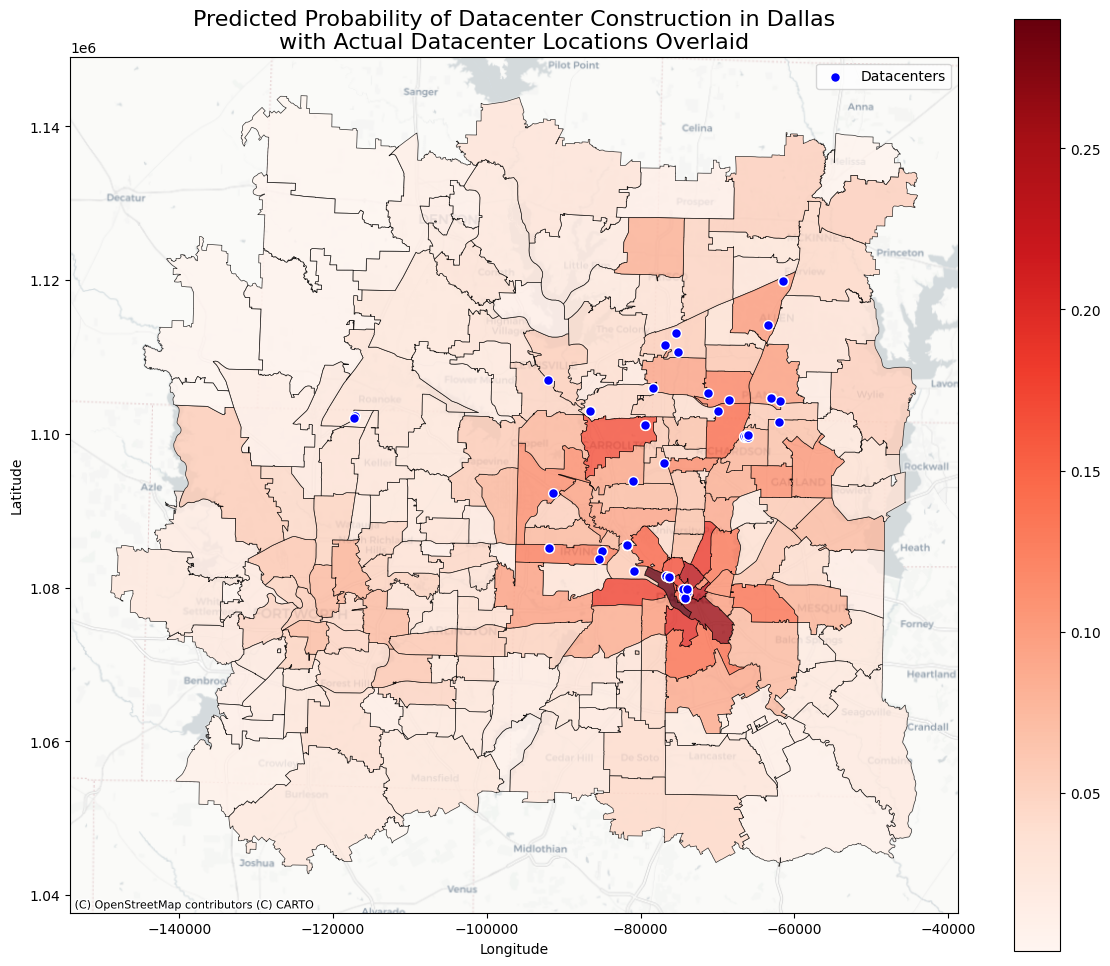

In [174]:
# Reproject the datacenter GeoDataFrame to match zcta_dallas CRS if necessary.
if gdf_datacenters_dallas.crs != zcta_dallas.crs:
    gdf_datacenters_dallas = gdf_datacenters_dallas.to_crs(zcta_dallas.crs)

fig, ax = plt.subplots(figsize=(12, 10))

# Plot the predicted probabilities (choropleth)
zcta_dallas.plot(column="predicted_prob", cmap="Reds", linewidth=0.5, 
                 edgecolor="black", legend=True, alpha=0.8, ax=ax)

# Overlay the actual datacenter locations as blue circles.
gdf_datacenters_dallas.plot(ax=ax, marker="o", color="blue", markersize=50, 
                             edgecolor="white", label="Datacenters")

# Add a basemap for context.
ctx.add_basemap(ax, crs=zcta_dallas.crs, source=ctx.providers.CartoDB.Positron)

# Set plot title and labels.
ax.set_title("Predicted Probability of Datacenter Construction in Dallas\nwith Actual Datacenter Locations Overlaid", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.tight_layout()
plt.show()


In [175]:
top50[['predicted_prob', 'datacenter_built']].sort_values('predicted_prob', ascending=False)

,predicted_prob,datacenter_built
75,0.240809,0
159,0.234627,0
88,0.147108,0
146,0.144335,1
37,0.134463,1
55,0.130800,0
130,0.123319,0
141,0.117846,1
9,0.109394,0
161,0.108500,0


In [178]:
# Sort the Texas GeoDataFrame by predicted probability in descending order
top50 = zcta_dallas.sort_values(by="predicted_prob", ascending=False).head(20)

# Count the number of top 50 ZCTAs that have a datacenter built (assuming 1 indicates built)
num_datacenters = top50["datacenter_built"].sum()
total_top50 = top50.shape[0]

print(f"In the top {total_top50} ZCTAs with the highest predicted probabilities, {num_datacenters} have a datacenter built.")
print(f"That's {num_datacenters/total_top50*100:.2f}% of the top 100.")

# Optionally, print a table showing the relevant columns
print(top50[["zcta5", "predicted_prob", "datacenter_built"]])


In the top 20 ZCTAs with the highest predicted probabilities, 7 have a datacenter built.
That's 35.00% of the top 100.
     zcta5  predicted_prob  datacenter_built
37   75207        0.290159                 1
75   75215        0.257536                 0
88   75204        0.232971                 0
159  75226        0.228146                 0
161  75203        0.195702                 0
146  75201        0.185167                 1
55   75206        0.184895                 0
89   75212        0.177395                 0
130  75219        0.169120                 0
158  75006        0.167792                 1
141  75202        0.155337                 1
114  75235        0.151092                 0
178  75080        0.143890                 1
9    75216        0.141927                 0
138  75227        0.139112                 0
51   75214        0.135118                 0
131  75061        0.128754                 1
176  75075        0.122762                 1
147  75246        0.118227

In [179]:
# 1. Obtain the predicted probabilities for the Dallas test set
y_pred_prob_dallas = model.predict_proba(X_test_dallas)[:, 1]  # Probability of the positive class
y_true_dallas = y_test_dallas  # True labels (0 or 1)

# 2. Compute ROC AUC
roc_auc = roc_auc_score(y_true_dallas, y_pred_prob_dallas)
print(f"ROC AUC on Dallas: {roc_auc:.4f}")

# 3. Compute Log Loss
ll = log_loss(y_true_dallas, y_pred_prob_dallas)
print(f"Log Loss on Dallas: {ll:.4f}")


ROC AUC on Dallas: 0.8293
Log Loss on Dallas: 0.2839


In [ ]:
# -----------------------------
# 6. Compute Permutation Importance on the Test Set
# -----------------------------
# Use the Dallas test set for permutation importance
X_test_dallas = dallas_df[final_features].copy()
y_test_dallas = dallas_df["datacenter_built"]

perm_importance = permutation_importance(model, X_test_dallas, y_test_dallas,
                                           scoring="roc_auc", n_repeats=30, random_state=42)

# -----------------------------
# 7. Build a Table of Coefficients and Feature Importance
# -----------------------------
importance_df = pd.DataFrame({
    "Feature": final_features,
    "Coefficient": model.coef_[0],
    "Abs Coefficient": np.abs(model.coef_[0]),
    "Perm. Importance Mean": perm_importance.importances_mean,
    "Perm. Importance Std": perm_importance.importances_std
}).sort_values(by="Perm. Importance Mean", ascending=False)

In [ ]:
print("Feature Coefficients and Permutation Importance:")
print(importance_df.to_string(index=False))

Feature Coefficients and Permutation Importance:
                Feature   Coefficient  Abs Coefficient  Perm. Importance Mean  Perm. Importance Std
        population_25km  1.078117e-06     1.078117e-06               0.138821              0.047651
       line_length_25km -9.360439e-05     9.360439e-05               0.016755              0.010598
        population_10km  6.324831e-07     6.324831e-07               0.014242              0.026021
 square_tower_count_1km  4.731480e-06     4.731480e-06               0.010799              0.001845
         population_5km  4.297466e-07     4.297466e-07               0.008410              0.010210
       line_length_10km -4.745347e-05     4.745347e-05               0.001993              0.003974
square_tower_count_50km  9.291339e-09     9.291339e-09               0.001582              0.001763
 square_tower_count_5km  7.829697e-08     7.829697e-08               0.000359              0.000438
                density -7.880542e-12     7.880542e